In [1]:
# Covid19 Analysis


In [2]:
# libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier



In [3]:
# reading dataset
# https://opendatasus.saude.gov.br/dataset/bd-srag-2020

df = pd.read_csv('/home/pedro/bkp/code/dataset/INFLUD-21-09-2020.csv',sep=';',encoding = "ISO-8859-1")

# Inputing constraint in the dataset 

# Positive case:

df = df[df['PCR_SARS2']==1]
print(df.shape)


# Hospitalized people:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110]
print(df.shape)

# Hospitalized people with age small than 110:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 3][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()]
print(df.shape)


#print(df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()].value_counts())
print(type(df))

/home/pedro/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15,60,62,63,64,92,94,108,117,121,123) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(299142, 154)


<ipython-input-3-e52a54bdc96a>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110]


(279982, 154)


<ipython-input-3-e52a54bdc96a>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 3][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()]


(242679, 154)
<class 'pandas.core.frame.DataFrame'>


In [4]:
# IDHM

# Reading IBGE code for each municipalities and separating it for IDHM index

df_atlas = pd.read_excel (r'/home/pedro/bkp/code/dataset/AtlasBrasil_Consulta.xlsx')


# removind last interger in 'code' variable

df_atlas['code'] = df_atlas['code'].astype(str).str[:-1].astype(np.int64)


# Divinding IDHM in bins

IDHM_veryhigh  =  set(df_atlas['code'][df_atlas['IDHM2010']>=0.800])
print(len(IDHM_veryhigh))


IDHM_high  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.700)&(df_atlas['IDHM2010']<0.800))])
print(len(IDHM_high))


IDHM_medium  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.600)&(df_atlas['IDHM2010']<0.700))])
print(len(IDHM_medium))


IDHM_low  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.500)&(df_atlas['IDHM2010']<0.600))])
print(len(IDHM_low))


IDHM_verylow  =  set(df_atlas['code'][df_atlas['IDHM2010']<0.500])
print(len(IDHM_verylow))




df.loc[df['CO_MUN_NOT'].isin(IDHM_veryhigh) == True, 'IDHM'] = 5
df.loc[df['CO_MUN_NOT'].isin(IDHM_high) == True, 'IDHM'] = 4
df.loc[df['CO_MUN_NOT'].isin(IDHM_medium) == True, 'IDHM'] = 3
df.loc[df['CO_MUN_NOT'].isin(IDHM_low) == True, 'IDHM'] = 2
df.loc[df['CO_MUN_NOT'].isin(IDHM_verylow) == True, 'IDHM'] = 1


# Municipalities number analysed
#print(df['IDHM'].isnull().sum())


44
1890
2233
1367
32


In [5]:
# Private and public hospital separation

df_hospital = pd.read_csv('/home/pedro/bkp/code/dataset/CNES_SUS.txt', sep='\t')


public   =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='S'])
private  =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='N'])


df.loc[df['CO_UNI_NOT'].isin(public) == True, 'HEALTH_SYSTEM'] = 1
df.loc[df['CO_UNI_NOT'].isin(private) == True, 'HEALTH_SYSTEM'] = 0

In [6]:
# Constraint on dataset: We only analyze people with  evolution, IDHM and Health system known

df = df[df['IDHM'].notnull()][(df['HEALTH_SYSTEM']==1)|(df['HEALTH_SYSTEM']==0)]
print(df.shape)


<ipython-input-6-cba1728feb81>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['IDHM'].notnull()][(df['HEALTH_SYSTEM']==1)|(df['HEALTH_SYSTEM']==0)]


(231112, 156)


In [7]:
# Selecting features
df = df[['NU_IDADE_N','HEALTH_SYSTEM','SUPORT_VEN','EVOLUCAO']]

In [8]:
# boxing the age feature

bins = [0, 40, 50, 60, 70, 150]
names = ['<40', '40-50', '50-60','60-70', '70>']
df['NU_IDADE_N'] = pd.cut(df['NU_IDADE_N'], bins=bins, labels=names, right= False)
df['NU_IDADE_N'] = df['NU_IDADE_N'].map({'<40': 40, '40-50':50, '50-60': 60 , '60-70':70, '70>':150})

print(df.shape)

(231112, 4)


In [9]:
df_missing = df.isnull().sum()
print(df_missing)

NU_IDADE_N           0
HEALTH_SYSTEM        0
SUPORT_VEN       23528
EVOLUCAO             0
dtype: int64


In [10]:
# Public and private hospital

public_hosp   = df['NU_IDADE_N'][df['HEALTH_SYSTEM'] == 1].shape[0] # public
private_hosp = df['NU_IDADE_N'][df['HEALTH_SYSTEM'] == 0].shape[0] # private



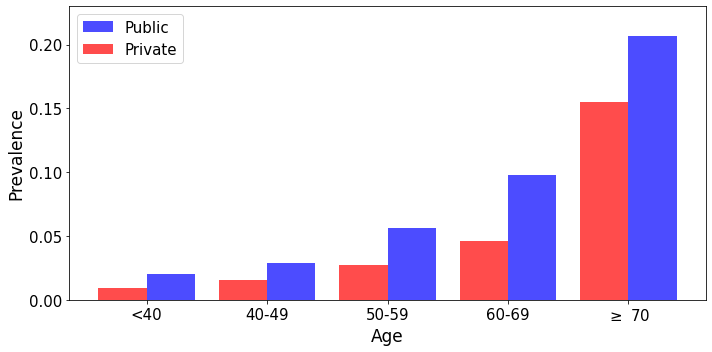

In [11]:
# Plotting figure

y_pos = np.arange(len(names))

age= df['NU_IDADE_N']

# Create horizontal bars
plt.figure(figsize=(10,5))


# Health System death people
a = df['NU_IDADE_N'][((df['HEALTH_SYSTEM'] == 1) & (df['EVOLUCAO'] == 1))].value_counts().sort_index(ascending=True) 
b = df['NU_IDADE_N'][((df['HEALTH_SYSTEM'] == 1) & (df['EVOLUCAO'] == 2))].value_counts().sort_index(ascending=True)
d = df['NU_IDADE_N'][((df['HEALTH_SYSTEM'] == 0) & (df['EVOLUCAO'] == 2))].value_counts().sort_index(ascending=True)
e = df['NU_IDADE_N'][((df['HEALTH_SYSTEM'] == 0) & (df['EVOLUCAO'] == 1))].value_counts().sort_index(ascending=True) 

grupos = 5
indice = np.arange(grupos)
bar_larg = 0.4
transp = 0.7
plt.bar(indice + 0.2, b.iloc[:]/public_hosp, bar_larg, alpha=0.7, color='blue', label='Public')
plt.bar(indice - 0.2, d.iloc[:]/private_hosp, bar_larg, alpha=0.7, color='red', label='Private')

plt.xticks(np.arange(5),['<40','40-49','50-59','60-69','$\geq$ 70'],fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left',fontsize=15) 
plt.ylabel('Prevalence',fontsize=17)
plt.xlabel('Age',fontsize=17)
plt.ylim([0, 0.23])
plt.tight_layout()
plt.savefig('private_public_new.pdf')
plt.show()



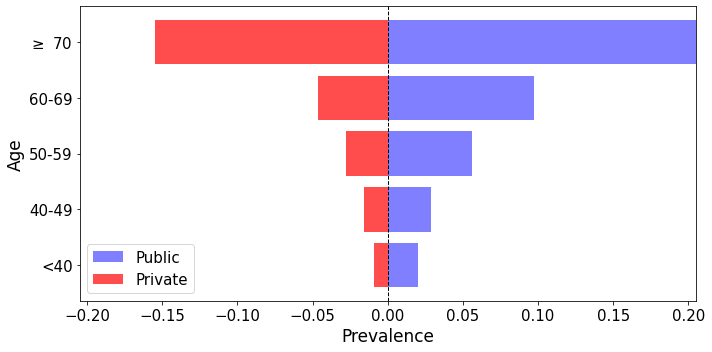

In [12]:
# Plotting figure

y_pos = np.arange(len(names))

age= df['NU_IDADE_N']

# Create horizontal bars
plt.figure(figsize=(10,5))


# Health System death people
a = df['NU_IDADE_N'][((df['HEALTH_SYSTEM'] == 1) & (df['EVOLUCAO'] == 1))].value_counts().sort_index(ascending=True) 
b = df['NU_IDADE_N'][((df['HEALTH_SYSTEM'] == 1) & (df['EVOLUCAO'] == 2))].value_counts().sort_index(ascending=True)
d = df['NU_IDADE_N'][((df['HEALTH_SYSTEM'] == 0) & (df['EVOLUCAO'] == 2))].value_counts().sort_index(ascending=True)
e = df['NU_IDADE_N'][((df['HEALTH_SYSTEM'] == 0) & (df['EVOLUCAO'] == 1))].value_counts().sort_index(ascending=True) 

grupos = 5
indice = np.arange(grupos)
bar_larg = 0.8
transp = 0.7
plt.barh(indice, b.iloc[:]/public_hosp, bar_larg, alpha=0.5, color='blue', label='Public')
plt.barh(indice, -d.iloc[:]/private_hosp, bar_larg, alpha=0.7, color='red', label='Private')


plt.axvline(x=0,color='k',linestyle='--',linewidth=1)
plt.yticks(np.arange(5),['<40','40-49','50-59','60-69','$\geq$ 70'],fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=15) 
#plt.title('Death',fontsize=17)
plt.xlabel('Prevalence',fontsize=17)
plt.ylabel('Age',fontsize=17)
plt.xlim([-0.205, 0.205])
plt.tight_layout()
plt.savefig('private_public_02.pdf')
plt.show()


In [13]:
# Quick test

# Death people for public and private 

print(b.sum())  # public
print(d.sum())  # private

df_check = df['NU_IDADE_N'][((df['HEALTH_SYSTEM'] == 1) & (df['EVOLUCAO'] == 2))].isnull().sum()
print(df_check)

75075
12148
0
